In [30]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
#import json
#import requests
import time
from us import states
import scipy.stats as st
import gmaps
from scipy.stats import linregress
import random 
import scipy.stats as stats

# gmaps API Keys
from config import (census_key, gkey)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [2]:
#testing 
!pwd

/c/Users/not4e/jupyterfun


In [3]:

#load data
csv_path = "Resources/NutritionPhysicalActivityandObesity.csv"
nutrition_data = pd.read_csv(csv_path)
#nutrition_data = pd.read_csv(csv_path, index_col ="LocationDesc")

# drop unesscary columns and fix labels
nutrition_data = nutrition_data.drop(columns=['Data_Value_Unit',
                                              'Stratification1',
                                             ])
#split lat and long
nutrition_data[['Lat','Long']] = nutrition_data.GeoLocation.str.split(",",expand=True,)
#nutrition_data[['openperen']] = nutrition_data.Lat.str.split('(',expand=False,)
#nutrition_data ['Lat'] = nutrition_data['Lat'].to_numeric()
#nutrition_data.dtypes



renamecols_df = nutrition_data.rename(columns={"LocationAbbr":"StateAbbr",
                           "LocationDesc":"State",
                            "Age(years)":"Age"})

#renamecols is df before narrowing age demographic
renamecols_df.head()




#clean split columns
##cols_to_clean = ['Lat']
#nutrition_data['Lat'] = pd.to_numeric(nutrition_data['Lat'])

##cols_to_clean = re.sub("[()]", "", str( cols_to_clean))
#print(cols_to_clean)
nutrition_data.head()

#rename labels
#renamecols_df = nutrition_data.rename(columns={"LocationAbbr":"StateAbbr",
                       #    "LocationDesc":"State",
                       #     "Age(years)":"Age"})

#renamecols is df before narrowing age demographic
#renamecols_df.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
0,2012,2012,WY,Wyoming,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,48.5,48.5,32.3,...,NaN,American Indian/Alaska Native,"43.235541343, -108.109830353",OWS,OWS1,Q037,56,Race/Ethnicity,43.235541343,-108.109830353
1,2012,2012,DC,District of Columbia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,31.6,31.6,24.0,...,NaN,NaN,"38.890371385, -77.031961127",OWS,OWS1,Q036,11,Education,38.890371385,-77.031961127
2,2011,2011,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,35.2,35.2,30.7,...,NaN,NaN,"32.840571122, -86.631860762",OWS,OWS1,Q036,1,Age (years),32.840571122,-86.631860762
3,2015,2015,RI,Rhode Island,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,40.2,40.2,33.3,...,NaN,Hispanic,"41.708280193, -71.522470314",OWS,OWS1,Q037,44,Race/Ethnicity,41.708280193,-71.522470314
4,2012,2012,WY,Wyoming,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,32.3,32.3,25.6,...,"Less than $15,000",NaN,"43.235541343, -108.109830353",PA,PA1,Q047,56,Income,43.235541343,-108.109830353


In [4]:
#trim age column to include only desired age demographic
agedem_df = renamecols_df.loc[(renamecols_df["Age"] == "18 - 24")
                               |(renamecols_df["Age"] == "25 - 34")
                               |(renamecols_df["Age"] == "35 - 44")
                               |(renamecols_df["Age"] == "45 - 54"),:]
#age is df with focus age deomographic
#while working on indivudal projects we should create and save a df with the needed data
agedem_df.tail()

#define dataframe for veggie and fruit analysis
#define dataframe for excercise/behavior analysis

#define dataframe for obesity rates for gen x and gen y
GenX_Data = agedem_df[(agedem_df["Age"] == "35 - 44") | 
                        (agedem_df["Age"] == "45 - 54")]
GenM_Data = agedem_df[(agedem_df["Age"] == "18 - 24") | 
                        (agedem_df["Age"] == "25 - 34")]


In [5]:
#moved to top
GenX_Data.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
26,2015,2015,NY,New York,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,29.7,29.7,26.7,...,NaN,NaN,"42.827001032, -75.543970427",OWS,OWS1,Q036,36,Age (years),42.827001032,-75.543970427
28,2013,2013,MT,Montana,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,35.5,35.5,31.7,...,NaN,NaN,"47.066528972, -109.424420645",PA,PA1,Q045,30,Age (years),47.066528972,-109.424420645
46,2013,2013,SD,South Dakota,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,38.2,38.2,32.6,...,NaN,NaN,"44.353130053, -100.373530637",OWS,OWS1,Q037,46,Age (years),44.353130053,-100.373530637
54,2013,2013,WA,Washington,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,33.3,33.3,30.5,...,NaN,NaN,"47.522278629, -120.47001079",OWS,OWS1,Q036,53,Age (years),47.522278629,-120.47001079
74,2011,2011,AZ,Arizona,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,34.5,34.5,29.7,...,NaN,NaN,"34.86597028, -111.763811277",PA,PA1,Q045,4,Age (years),34.86597028,-111.763811277


In [6]:
#moved to top

GenM_Data.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
2,2011,2011,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,35.2,35.2,30.7,...,NaN,NaN,"32.840571122, -86.631860762",OWS,OWS1,Q036,1,Age (years),32.840571122,-86.631860762
37,2011,2011,ME,Maine,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in muscle-strengt...,42.2,42.2,36.9,...,NaN,NaN,"45.254228894001, -68.985031336",PA,PA1,Q046,23,Age (years),45.254228894001,-68.985031336
39,2012,2012,AK,Alaska,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,12.8,12.8,9.8,...,NaN,NaN,"64.845079957001, -147.722059036",PA,PA1,Q047,2,Age (years),64.845079957001,-147.722059036
62,2013,2013,DC,District of Columbia,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,32.3,32.3,27.0,...,NaN,NaN,"38.890371385, -77.031961127",PA,PA1,Q045,11,Age (years),38.890371385,-77.031961127
70,2014,2014,NM,New Mexico,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,33.2,33.2,28.6,...,NaN,NaN,"34.520880952, -106.240580985",OWS,OWS1,Q036,35,Age (years),34.520880952,-106.240580985


In [7]:
GenM_Weight_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
GenX_Weight_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]

In [8]:
GenX_activity_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
GenM_activity_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]

In [9]:
GenM_nutrition_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")|(GenM_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]
GenX_nutrition_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who report consuming vegetables less than one time daily")|(GenX_Data["Question"] == "Percent of adults who report consuming fruit less than one time daily")]

In [12]:
GenX_sample_list = GenX_Weight_df["Data_Value"].tolist()
GenX_WeightSample = random.sample(GenX_sample_list, 204)

In [13]:
GenM_sample_list = GenM_Weight_df["Data_Value"].tolist()
GenM_WeightSample = random.sample(GenM_sample_list, 204)

The correlation between both factors is 0.0


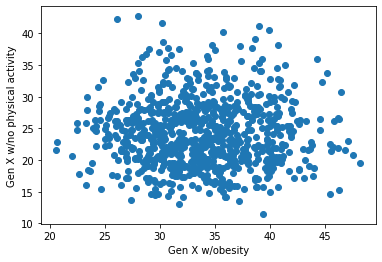

In [14]:
# The next example will compute the Pearson correlation coefficient between "GenX_Weight" and "GenX_Activity"
GenX_Weight = GenX_Weight_df.iloc[:,7]
GenX_Activity = GenX_activity_df.iloc[:,7]
correlation = st.pearsonr(GenX_Weight,GenX_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_Weight,GenX_Activity)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is 0.03


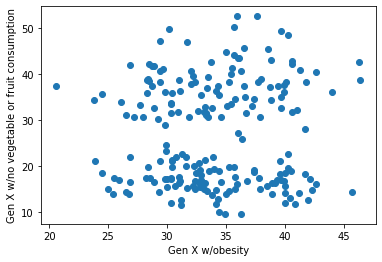

In [15]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenX_WeightSample = GenX_WeightSample
GenX_Nutrition = GenX_nutrition_df.iloc[:,7]
correlation = st.pearsonr(GenX_WeightSample,GenX_Nutrition)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_WeightSample,GenX_Nutrition)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no vegetable or fruit consumption')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is 0.03


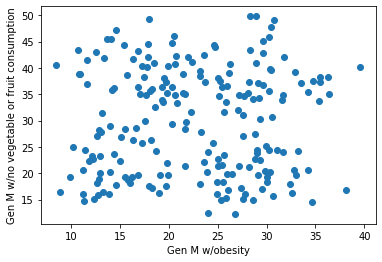

In [16]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_WeightSample = GenM_WeightSample
GenM_Nutrition = GenM_nutrition_df.iloc[:,7]
correlation = st.pearsonr(GenM_WeightSample,GenM_Nutrition)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_WeightSample,GenM_Nutrition)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no vegetable or fruit consumption')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is 0.04


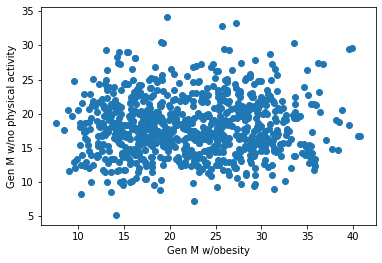

In [17]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_Weight = GenM_Weight_df.iloc[:,7]
GenM_Activity = GenM_activity_df.iloc[:,7]
correlation = st.pearsonr(GenM_Weight,GenM_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_Weight,GenM_Activity)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The r-squared is: 0.0013907261339774725


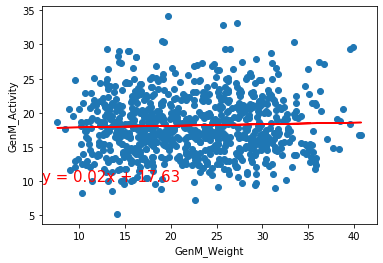

In [19]:
# Print out the r-squared value along with the plot.
x_values = GenM_Weight
y_values = GenM_Activity
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('GenM_Weight')
plt.ylabel('GenM_Activity')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [51]:
Top10 = GenX_Weight_df.sort_values('Data_Value', ascending = False).head(10)
Top10

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
12713,2018,2018,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,48.2,48.2,44.0,...,NaN,NaN,"38.66551020200046, -80.71264013499967",OWS,OWS1,Q036,54,Age (years),38.66551020200046,-80.71264013499967
3308,2016,2016,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,47.5,47.5,42.7,...,NaN,NaN,"32.745510099, -89.538030825",OWS,OWS1,Q036,28,Age (years),32.745510099,-89.538030825
26018,2017,2017,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,47.1,47.1,43.2,...,NaN,NaN,"32.840571122, -86.631860762",OWS,OWS1,Q036,1,Age (years),32.840571122,-86.631860762
16626,2017,2017,LA,Louisiana,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.8,46.8,42.2,...,NaN,NaN,"31.312660644, -92.445680071",OWS,OWS1,Q036,22,Age (years),31.312660644,-92.445680071
29607,2017,2017,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.4,46.4,42.6,...,NaN,NaN,"38.665510202, -80.712640135",OWS,OWS1,Q036,54,Age (years),38.665510202,-80.712640135
2328,2016,2016,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.3,46.3,43.0,...,NaN,NaN,"38.665510202, -80.712640135",OWS,OWS1,Q036,54,Age (years),38.665510202,-80.712640135
7544,2018,2018,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.3,46.3,42.4,...,NaN,NaN,"32.745510099000455, -89.53803082499968",OWS,OWS1,Q036,28,Age (years),32.745510099000455,-89.53803082499968
15140,2013,2013,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.2,46.2,42.4,...,NaN,NaN,"32.745510099, -89.538030825",OWS,OWS1,Q036,28,Age (years),32.745510099,-89.538030825
11386,2018,2018,WV,West Virginia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,46.2,46.2,41.5,...,NaN,NaN,"38.66551020200046, -80.71264013499967",OWS,OWS1,Q036,54,Age (years),38.66551020200046,-80.71264013499967
9117,2018,2018,LA,Louisiana,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,45.8,45.8,41.6,...,NaN,NaN,"31.31266064400046, -92.44568007099969",OWS,OWS1,Q036,22,Age (years),31.31266064400046,-92.44568007099969


In [57]:
# Store 'Lat' and 'Lng' into  locations 
locations = Top10[["Lat", "Long"]].astype(float)


# Convert Obesity Rate to float and store
obesity_rate = Top10["Data_Value"].astype(float)

In [59]:
# Create a GenX Heatmap layer
fig = gmaps.figure()

GenX_heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(GenX_heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [60]:
Top10_GenM = GenM_Weight_df.sort_values('Data_Value', ascending = False).head(10)

In [61]:
# Convert activity rate to list
GenM_Obesity_rate = Top10_GenM["Data_Value"].tolist()

In [63]:
# Create a GenM Heatmap layer
fig = gmaps.figure()

GenM_heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(GenM_heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [64]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(GenX_heat_layer)
fig.add_layer(GenM_heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [27]:
def gendata(loc=0):
    GenX = GenX_Weight_df["Data_Value"]
    GenM = GenM_Weight_df["Data_Value"]

    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(GenX)), GenX, label="GenX")
    plt.scatter(range(len(GenM)), GenM, label="GenM")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(GenX, 20, density=True, alpha=0.7, label="GenX")
    plt.hist(GenM, 20, density=True, alpha=0.7, label="GenM")
    plt.axvline(GenX.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(GenM.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return GenX, GenM

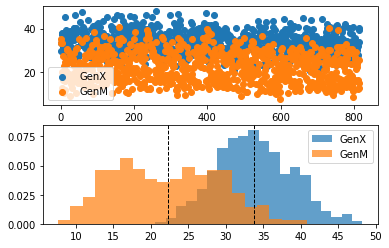

In [28]:
GenX, GenM = gendata()

In [32]:
stats.ttest_ind(GenX, GenM, equal_var=False)

Ttest_indResult(statistic=38.250788848876255, pvalue=6.906377165120682e-223)